#Set up and Import dependencies

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 18 04:17:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install bs4 

In [ ]:
pip install google_trans_new

In [ ]:
import sys 
print(sys.version)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds 
import re 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM , Bidirectional , Embedding 
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from google_trans_new import google_translator  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score , roc_curve

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Define functions 

In [ ]:
#read textfile 
def get_data(str):
  """
  read data from text file 
  """
  df = pd.read_fwf(str,header=None)
  return df 



#translate foreign languages 
def translate_foreign_language(df,translator):
  """detect_foreign_language(df) : 
  detects foreign language in the dataset 
  and translates it to English. 

  Parameters : 
  df ==> dataset that needs to be translated. 
  """
  df_1 = []
  for i,line in enumerate(df):
    translate_text = translator.translate(line,lang_tgt='en')
    df_1.append(translate_text)
  return df_1
    


#check foreign languages 
def isEnglish(df):
  """isEnligh(df) : 
  checks whether the dataset is only in English language 

  Parameters: 
  df ==> the dataset that needs to be checked 
  """
  count = 0
  detector = google_translator()
  for line in df:
    detect_result = detector.detect(line)
    if(detect_result[0] != 'en'):
      count += 1 
      print(line)
  print("There are",count,"foreign languages detected in the dataset.")

#first stage of preprocessing 
def preprocessing_1(df):
  """preprocessing_1(df) : 
   The first preprocessing stage where this function removes HTML tags, 
   numerical values, hyperlinks, punctuations 

   Parameters : 
   df ==> The dataset that needs to be preprocessed 
  """
  df_1 = [] #empty to list to store preprocessed text 
  #initialize stop words method 
  stop_words = set(stopwords.words('english'))
  for row in df:
    row = BeautifulSoup(row).get_text()
    row = re.sub("[^a-zA-Z]",' ',row)
    row = row.lower()
    row = re.sub(r'^https?:\/\/.*[\r\n]*', '', row, flags=re.MULTILINE)
    row = row.split()
    row = [w for w in row if w not in stop_words] 
    row = " ".join(row)
    df_1.append(row)
    df_2 = list(filter(None,df_1))
  
  return df_2

#word2vec encoding method 
def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    # Load Pretrained Word2Vec
    embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

#get max length of the sentences 
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['review']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

#pad the sequences 
def get_padded_encoded_reviews(encoded_reviews,max_length):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

#encode words into word2vec 
def preprocess_2(df,str):
    """
    encode training text value to numeric value
    parameters : 
    df ==> dataset 
    str ==> identification of dataset(training or prediction)
    """
    if (str.lower()=="training"):
      reviews = df['review'].tolist()
      max_length = get_max_length(df)
      encoded_reviews = get_word2vec_enc(reviews)
      padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews,max_length)
      X = np.array(padded_encoded_reviews)
      Y = np.array(df['sentiment'])
      return X, Y 
    elif (str.lower()=="predictions"):
      reviews = df['review'].tolist()
      max_length = get_max_length(data_preprocessed_1)
      encoded_reviews = get_word2vec_enc(reviews)
      padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews,max_length)
      X = np.array(padded_encoded_reviews)
      return X
    else :
      print("Error : Input should be either 'training' or 'predictions'")
 

def round_off(x):
  return np.round(x)


def count(df):
  count1 = 0
  count2 = 0
  for elem in df:
    if (elem==1):
      count1 +=1 
    elif (elem==0):
      count2+=1
  return count1 , count2 






#Pre-process the training dataset

load the dataset

In [ ]:
#training datset
data = pd.read_csv("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 1/data/dataset-primary/labeledTrainData.tsv/labeledTrainData.tsv",sep="\t")

In [ ]:
#only use 1000 rows from the dataset 
data = data[0:1000]

In [ ]:
#data before preprocessing 
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
isEnglish(data)

There are 0 foreign languages detected in the dataset.


In [ ]:
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

In [ ]:
df = preprocessing_1(data['review'])

In [ ]:
df = pd.DataFrame(df) 

In [ ]:
#create a dataframe to store preprocessed training data 
data_preprocessed_1 = pd.DataFrame()
data_preprocessed_1['sentiment'] = data['sentiment'] 
data_preprocessed_1['review'] = df 

In [ ]:
#sample of the preprocessed training data 
data_preprocessed_1.head()

,sentiment,review
0,1,stuff going moment mj started listening music ...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious explo...


In [ ]:
X , y = preprocess_2(data_preprocessed_1,"training")

In [ ]:
#find training data size and testing data size 
train_size = int(len(data_preprocessed_1) * 0.7) 
test_size = int(len(data_preprocessed_1) - train_size) 
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
#shape of training and testing datasets 
print("Training size ==>",train_size)
print("Testing size ==>",test_size)
print("Shape of X_train==>",X_train.shape)
print("Shape of y_train ==>",y_train.shape)
print("Shape of X_test==>",X_test.shape)
print("Shape of y_test ==>",y_test.shape)

Training size ==> 700
Testing size ==> 300
Shape of X_train==> (700, 558, 250)
Shape of y_train ==> (700,)
Shape of X_test==> (300, 558, 250)
Shape of y_test ==> (300,)


In [ ]:
X_test

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.07588305, -0.09483378,  0.06895591, ..., -0.02515614,
          0.06868097, -0.03088493],
        [ 0.0042055 , -0.09185704,  0.04232814, ...,  0.03552533,
          0.0508754 ,  0.01413414],
        [-0.06695258, -0.07236093, -0.02306525, ..., -0.10517108,
         -0.03864121,  0.00326741]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.08633253, -0.09760925,  0.01991028, ...,  

#Pre-process data for prediction 

In [ ]:
watchmen_review = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/watchmen.txt")

In [ ]:
interstellar_review = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/interstellar_2014.txt")

In [ ]:
love_and_monsters_review = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/love_and_monsters.txt")

In [ ]:
john_wick_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/john_wick.txt")

In [ ]:
mortal_kombat_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/mortal_kombat_2021.txt")

In [ ]:
spiderman_homecoming_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/spider_man_homecoming.txt")

In [ ]:
army_of_dead_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/the_army_of_dead.txt")

In [ ]:
dark_knight_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/the_dark_knight_review.txt")

In [ ]:
the_hitman_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/the_hitmans_bodyguard.txt")

In [ ]:
woman_in_window_reviews = get_data("/content/drive/MyDrive/Taylors/assignments/NLP/assignment 2/data/the_woman_in_the_window.txt")

##Data Preprocessing 

In [ ]:
print("Watchmen reviews:\n")
print(watchmen_review)
print("Interstellar reviews:\n")
print(interstellar_review)
print("The hitman's bodyguard reviews:\n")
print(the_hitman_reviews)
print("Spiderman Homecoming reviews:\n")
print(spiderman_homecoming_reviews)
print("Love and Monsters reviews:\n")
print(love_and_monsters_review)
print("John Wick reviews:\n")
print(john_wick_reviews)
print("Mortal Kombat reviews:\n")
print(mortal_kombat_reviews)
print("Army of the dead reviews:\n")
print(army_of_dead_reviews)
print("The dark knight reviews:\n")
print(dark_knight_reviews)
print("The woman in the window reviews:\n")
print(woman_in_window_reviews)

Watchmen reviews:

                                                     0
0    Undeniably, skilfully and wholeheartedly reali...
1    Snyder has done a good job of staying true to ...
2    Outside of Haley's turn as Rorschach, the cast...
3    Snyder's film is a breath-taking epic, a compe...
4    Watchmen really does work as a film, by stayin...
..                                                 ...
135  You may frequently wonder why Snyder has bothe...
136  This is a landmark film for the genre that wil...
137  This despicable trash will find an audience am...
138  Watchmen is a spectacular visual treat, with s...
139           The unfilmable has become the unlovable.

[140 rows x 1 columns]
Interstellar reviews:

                                                     0    1    2    3
0                                                  NaN  NaN  NaN  NaN
1                                                  NaN  NaN  NaN  NaN
2    Preposterous, pseudointellectual, poorly const...  NaN  NaN

##Drop the unwanted columns 

In [ ]:
#drop the unwanted columns in the datasets 
interstellar_review = interstellar_review.drop([1,2,3],axis=1)
spiderman_homecoming_reviews = spiderman_homecoming_reviews.drop([1],axis=1)
love_and_monsters_review = love_and_monsters_review.drop([1],axis=1)
john_wick_reviews = john_wick_reviews.drop([1,2,3,4],axis=1)
mortal_kombat_reviews = mortal_kombat_reviews.drop([1,2,3,4],axis=1)
army_of_dead_reviews = army_of_dead_reviews.drop([1,2,3],axis=1)
woman_in_window_reviews = woman_in_window_reviews.drop([1],axis=1)

##Missing Data

###Find missing values 

In [ ]:
print("<Before cleaning>")
print("<--------------------------------------------------------->")
print("Love and monsters :")
print(love_and_monsters_review.isnull().sum())
print("<--------------------------------------------------------->")
print("Interstellar :")
print(interstellar_review.isnull().sum())
print("<--------------------------------------------------------->")
print("John wick :")
print(john_wick_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Army of dead :")
print(army_of_dead_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The woman in window :")
print(woman_in_window_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Spiderman homecoming :")
print(spiderman_homecoming_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The dark knight :")
print(dark_knight_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Mortal Kombat :")
print(mortal_kombat_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The hitman's body guard :")
print(the_hitman_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Watchmen :")
print(watchmen_review.isnull().sum())
print("<--------------------------------------------------------->")

<Before cleaning>
<--------------------------------------------------------->
Love and monsters :
0    310
dtype: int64
<--------------------------------------------------------->
Interstellar :
0    421
dtype: int64
<--------------------------------------------------------->
John wick :
0    421
dtype: int64
<--------------------------------------------------------->
Army of dead :
0    421
dtype: int64
<--------------------------------------------------------->
The woman in window :
0    421
dtype: int64
<--------------------------------------------------------->
Spiderman homecoming :
0    361
dtype: int64
<--------------------------------------------------------->
The dark knight :
0    0
dtype: int64
<--------------------------------------------------------->
Mortal Kombat :
0    421
dtype: int64
<--------------------------------------------------------->
The hitman's body guard :
0    0
dtype: int64
<--------------------------------------------------------->
Watchmen :
0    0
dty

###Drop the missing values 

In [ ]:
#drop the missing values 
interstellar_review = interstellar_review.dropna()
love_and_monsters_review = love_and_monsters_review.dropna()
john_wick_reviews = john_wick_reviews.dropna()
mortal_kombat_reviews = mortal_kombat_reviews.dropna()
army_of_dead_reviews = army_of_dead_reviews.dropna()
woman_in_window_reviews = woman_in_window_reviews.dropna()
spiderman_homecoming_reviews = spiderman_homecoming_reviews.dropna()

In [ ]:
print("<After cleaning>")
print("<--------------------------------------------------------->")
print("Love and monsters :")
print(love_and_monsters_review.isnull().sum())
print("<--------------------------------------------------------->")
print("Interstellar :")
print(interstellar_review.isnull().sum())
print("<--------------------------------------------------------->")
print("John wick :")
print(john_wick_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Army of dead :")
print(army_of_dead_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The woman in window :")
print(woman_in_window_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Spiderman homecoming :")
print(spiderman_homecoming_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The dark knight :")
print(dark_knight_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Mortal Kombat :")
print(mortal_kombat_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("The hitman's body guard :")
print(the_hitman_reviews.isnull().sum())
print("<--------------------------------------------------------->")
print("Watchmen :")
print(watchmen_review.isnull().sum())
print("<--------------------------------------------------------->")

<After cleaning>
<--------------------------------------------------------->
Love and monsters :
0    0
dtype: int64
<--------------------------------------------------------->
Interstellar :
0    0
dtype: int64
<--------------------------------------------------------->
John wick :
0    0
dtype: int64
<--------------------------------------------------------->
Army of dead :
0    0
dtype: int64
<--------------------------------------------------------->
The woman in window :
0    0
dtype: int64
<--------------------------------------------------------->
Spiderman homecoming :
0    0
dtype: int64
<--------------------------------------------------------->
The dark knight :
0    0
dtype: int64
<--------------------------------------------------------->
Mortal Kombat :
0    0
dtype: int64
<--------------------------------------------------------->
The hitman's body guard :
0    0
dtype: int64
<--------------------------------------------------------->
Watchmen :
0    0
dtype: int64
<----

###Preprocessing 1

In [ ]:
#first stage preprocessing for the prediction datasets 
love_and_monsters_review_preprocessed_1 = preprocessing_1(love_and_monsters_review[0])
interstellar_review_preprocessed_1 = preprocessing_1(interstellar_review[0])
john_wick_reviews_preprocessed_1 =  preprocessing_1(john_wick_reviews[0])
army_of_dead_reviews_preprocessed_1 = preprocessing_1(army_of_dead_reviews[0])
woman_in_window_reviews_preprocessed_1 = preprocessing_1(woman_in_window_reviews[0])
spiderman_homecoming_reviews_preprocessed_1 = preprocessing_1(spiderman_homecoming_reviews[0])
dark_knight_reviews_preprocessed_1 = preprocessing_1(dark_knight_reviews[0])
mortal_kombat_reviews_preprocessed_1 = preprocessing_1(mortal_kombat_reviews[0])
the_hitman_reviews_preprocessed_1 = preprocessing_1(the_hitman_reviews[0])
watchmen_review_preprocessed_1 = preprocessing_1(watchmen_review[0])

###Detect Foreign Language 

In [ ]:
print("<--------------------------------------------------------->")
print("Love and monsters :")
isEnglish(love_and_monsters_review_preprocessed_1)
print("<--------------------------------------------------------->")
print("Interstellar :")
isEnglish(interstellar_review_preprocessed_1)
print("<--------------------------------------------------------->")
print("John wick :")
isEnglish(john_wick_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("Army of dead :")
isEnglish(army_of_dead_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("The woman in window :")
isEnglish(woman_in_window_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("Spiderman homecoming :")
isEnglish(spiderman_homecoming_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("The dark knight :")
isEnglish(dark_knight_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("Mortal Kombat :")
isEnglish(mortal_kombat_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("The hitman's body guard :")
isEnglish(the_hitman_reviews_preprocessed_1)
print("<--------------------------------------------------------->")
print("Watchmen :")
isEnglish(watchmen_review_preprocessed_1)
print("<--------------------------------------------------------->")

<--------------------------------------------------------->
Love and monsters :
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
Interstellar :
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
John wick :
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
Army of dead :
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
The woman in window :
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
Spiderman homecoming :
tom holland peter parker
There are 1 foreign languages detected in the dataset.
<--------------------------------------------------------->
The dark knight :
najefektniji u trenucima kada se kr u e nepisana pravila
lo mejor por lejos la descollante actuaci n

###Translate Foreign Language 

In [ ]:
#intialize the translator 
translator = google_translator()
#translate datasets with foreign language
translated_watchmen = translate_foreign_language(watchmen_review_preprocessed_1,translator)
translated_dark_knight = translate_foreign_language(dark_knight_reviews_preprocessed_1,translator)

In [ ]:
print("<--------------------------------------------------------->")
print("Dark knight reviews after translation:")
isEnglish(translated_dark_knight)
print("<--------------------------------------------------------->")
print("Watchmen reviews after translation:")
isEnglish(translated_watchmen)
print("<--------------------------------------------------------->")

<--------------------------------------------------------->
Dark knight reviews after translation:
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->
Watchmen reviews after translation:
There are 0 foreign languages detected in the dataset.
<--------------------------------------------------------->


###Preprocess 2 - Encoding 

In [ ]:
#convert lists to dataframe 
love_and_monsters_review_df = pd.DataFrame(love_and_monsters_review_preprocessed_1,columns=['review'])
interstellar_review_df = pd.DataFrame(interstellar_review_preprocessed_1,columns=['review'])
john_wick_review_df = pd.DataFrame(john_wick_reviews_preprocessed_1,columns=['review'])
army_of_dead_reviews_df = pd.DataFrame(army_of_dead_reviews_preprocessed_1,columns=['review'])
woman_in_window_reviews_df = pd.DataFrame(woman_in_window_reviews_preprocessed_1,columns=['review'])
spiderman_homecoming_reviews_df = pd.DataFrame(spiderman_homecoming_reviews_preprocessed_1,columns=['review'])
dark_knight_reviews_df = pd.DataFrame(dark_knight_reviews_preprocessed_1,columns=['review'])
mortal_kombat_reviews_df = pd.DataFrame(mortal_kombat_reviews_preprocessed_1,columns=['review'])
the_hitman_reviews_df = pd.DataFrame(the_hitman_reviews_preprocessed_1,columns=['review'])
watchmen_review_df = pd.DataFrame(watchmen_review_preprocessed_1,columns=['review'])


In [ ]:
#encode the prediction datasets 
love_and_monsters_encoded = preprocess_2(love_and_monsters_review_df,"predictions")
interstellar_encoded = preprocess_2(interstellar_review_df,"predictions")
john_wick_encoded = preprocess_2(john_wick_review_df,"predictions")
army_of_dead_encoded = preprocess_2(army_of_dead_reviews_df,"predictions")
woman_in_window_encoded = preprocess_2(woman_in_window_reviews_df,"predictions")
spiderman_homecoming_encoded = preprocess_2(spiderman_homecoming_reviews_df,"predictions")
dark_knight_encoded = preprocess_2(dark_knight_reviews_df,"predictions")
mortal_kombat_encoded = preprocess_2(mortal_kombat_reviews_df,"predictions")
the_hitman_encoded = preprocess_2(the_hitman_reviews_df,"predictions")
watchmen_encoded = preprocess_2(watchmen_review_df,"predictions")

In [ ]:
print("<--------------------------------------------------------->")
print("Love and monsters encoded shape ==>",love_and_monsters_encoded.shape)
print("<--------------------------------------------------------->")
print("Interstellar encoded shape ==>",interstellar_encoded.shape)
print("<--------------------------------------------------------->")
print("John wick encoded shape ==>",john_wick_encoded.shape)
print("<--------------------------------------------------------->")
print("Army of dead encoded shape ==>",army_of_dead_encoded.shape)
print("<--------------------------------------------------------->")
print("The woman in window encoded shape ==>",woman_in_window_encoded.shape)
print("<--------------------------------------------------------->")
print("Spiderman homecoming encoded shape ==>",spiderman_homecoming_encoded.shape)
print("<--------------------------------------------------------->")
print("The dark knight encoded shape ==>",dark_knight_encoded.shape)
print("<--------------------------------------------------------->")
print("Mortal Kombat encoded shape ==>",mortal_kombat_encoded.shape)
print("<--------------------------------------------------------->")
print("The hitman's body guard encoded shape ==>",the_hitman_encoded.shape)
print("<--------------------------------------------------------->")
print("Watchmen encoded shape ==>",watchmen_encoded.shape)
print("<--------------------------------------------------------->")

<--------------------------------------------------------->
Love and monsters encoded shape ==> (102, 558, 250)
<--------------------------------------------------------->
Interstellar encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
John wick encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
Army of dead encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
The woman in window encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
Spiderman homecoming encoded shape ==> (120, 558, 250)
<--------------------------------------------------------->
The dark knight encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
Mortal Kombat encoded shape ==> (140, 558, 250)
<--------------------------------------------------------->
The hitman's body guard encoded shape ==> (140, 558, 250)
<----

#Model Building

In [ ]:
#define the model
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
#compile the model 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#summary of the model
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 558, 64)           80640     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 93,089
Trainable params: 93,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train,   #training sequence
    y_train, # training labels
    epochs=50,
    validation_data=(X_test,y_test))

Epoch 1/50
22/22 [==============================] - 6s 106ms/step - loss: 0.6844 - accuracy: 0.5629 - val_loss: 0.6626 - val_accuracy: 0.6300
Epoch 2/50
22/22 [==============================] - 1s 64ms/step - loss: 0.5832 - accuracy: 0.7129 - val_loss: 0.5800 - val_accuracy: 0.6667
Epoch 3/50
22/22 [==============================] - 1s 64ms/step - loss: 0.5399 - accuracy: 0.7314 - val_loss: 0.5902 - val_accuracy: 0.6900
Epoch 4/50
22/22 [==============================] - 1s 65ms/step - loss: 0.5062 - accuracy: 0.7543 - val_loss: 0.5308 - val_accuracy: 0.7267
Epoch 5/50
22/22 [==============================] - 1s 64ms/step - loss: 0.4776 - accuracy: 0.7729 - val_loss: 0.5194 - val_accuracy: 0.7433
Epoch 6/50
22/22 [==============================] - 1s 65ms/step - loss: 0.4486 - accuracy: 0.7957 - val_loss: 0.5144 - val_accuracy: 0.7433
Epoch 7/50
22/22 [==============================] - 1s 64ms/step - loss: 0.5113 - accuracy: 0.7829 - val_loss: 0.6090 - val_accuracy: 0.6733
Epoch 8/50
2

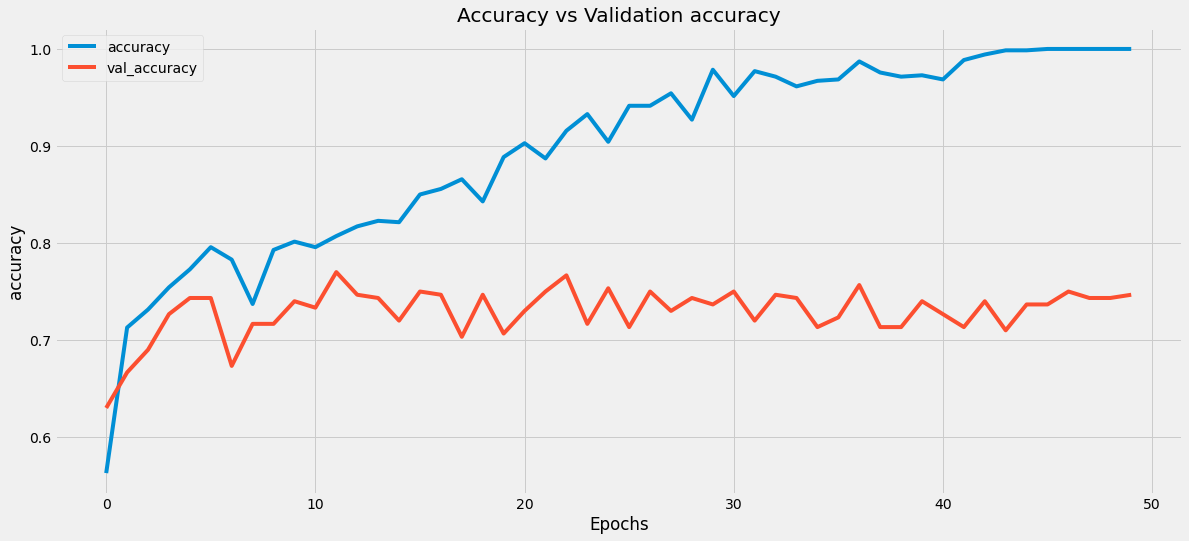

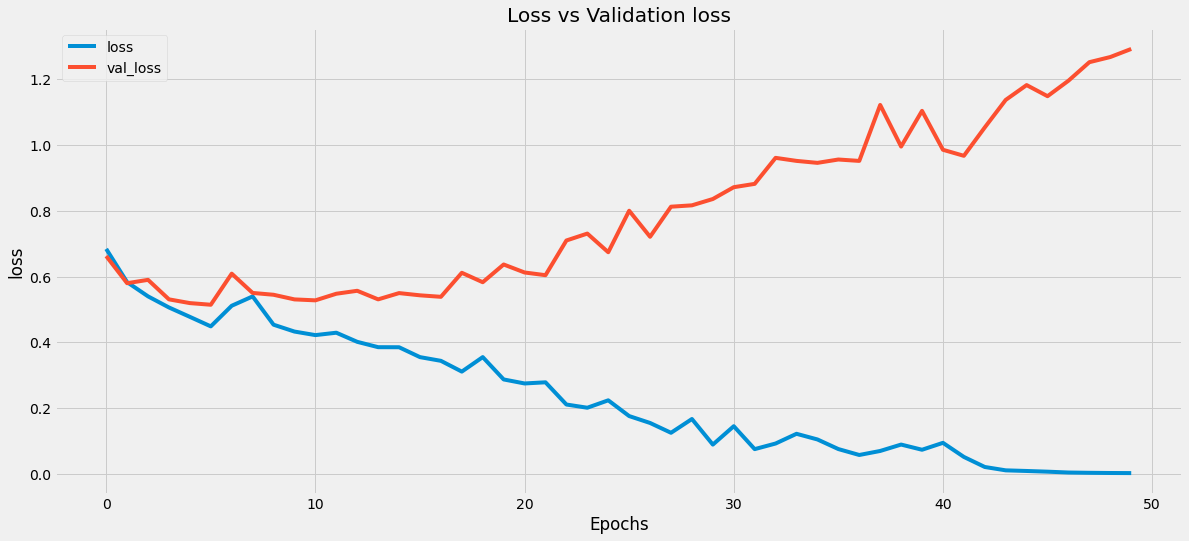

In [ ]:
##plot the scores from history
def plot_metrics(history, metric,title):
  plt.figure(figsize=(18,8))
  plt.title(title)
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric])
  plt.legend([metric, 'val_'+ metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.style.use('fivethirtyeight')
  plt.show()
  
##plot accuracy
plot_metrics(history, "accuracy","Accuracy vs Validation accuracy")

##plot loss
plot_metrics(history, "loss","Loss vs Validation loss")

In [ ]:
#make prediction based on 
prediction = model.predict(X_test)

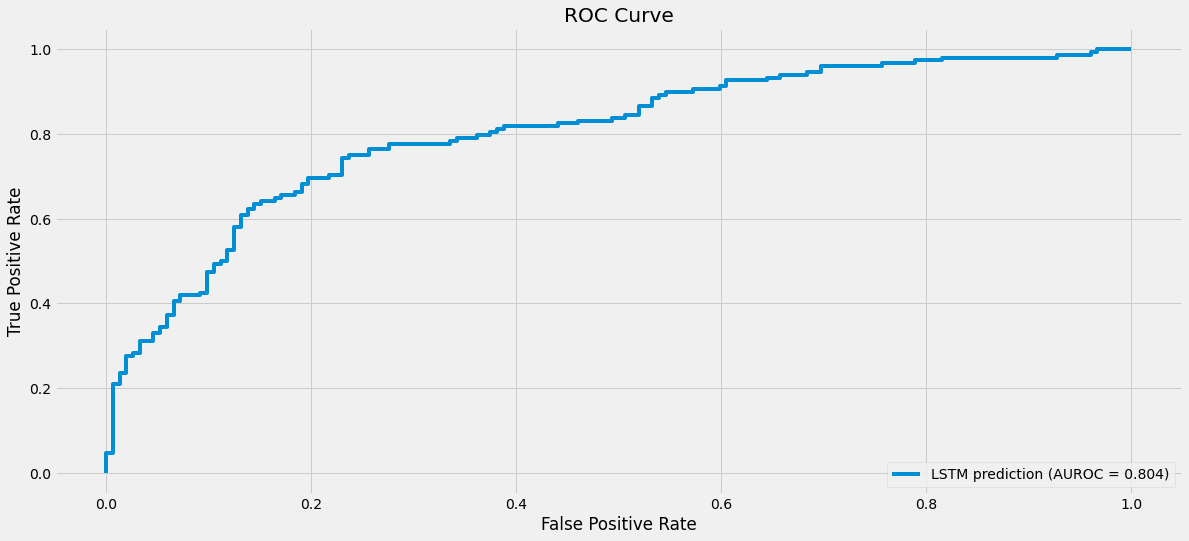

In [ ]:
#calculate the roc_auc score and roc_curve score 
auc_prediction = roc_auc_score(y_test,prediction)
prediction_fpr , prediction_tpr , _ = roc_curve(y_test,prediction)

#plot the roc curve 
plt.figure(figsize=(18,8))
plt.plot(prediction_fpr,prediction_tpr,label='LSTM prediction (AUROC = %0.3f)'%auc_prediction)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#predict the polarity of the movie reviews 
love_and_monsters_prediction = model.predict(love_and_monsters_encoded)
interstellar_prediction = model.predict(interstellar_encoded)
john_wick_prediction = model.predict(john_wick_encoded)
army_of_dead_prediction = model.predict(army_of_dead_encoded)
woman_in_window_prediction = model.predict(woman_in_window_encoded)
spiderman_homecoming_prediction = model.predict(spiderman_homecoming_encoded)
dark_knight_prediction = model.predict(dark_knight_encoded)
mortal_kombat_prediction = model.predict(mortal_kombat_encoded)
the_hitman_prediction = model.predict(the_hitman_encoded)
watchmen_prediction = model.predict(watchmen_encoded)

In [ ]:
# round off the answer 
love_and_monsters_prediction_round = round_off(love_and_monsters_prediction)
interstellar_prediction_round = round_off(interstellar_prediction)
john_wick_prediction_round = round_off(john_wick_prediction)
army_of_dead_prediction_round = round_off(army_of_dead_prediction)
woman_in_window_prediction_round = round_off(woman_in_window_prediction)
spiderman_homecoming_prediction_round = round_off(spiderman_homecoming_prediction)
dark_knight_prediction_round = round_off(dark_knight_prediction)
mortal_kombat_prediction_round = round_off(mortal_kombat_prediction)
the_hitman_prediction_round = round_off(the_hitman_prediction)
watchmen_prediction_round = round_off(watchmen_prediction)

In [ ]:
#define rating function 
rating = lambda x , y ,z:  ((x*0.1+y*0.05)/len(z))*100

In [ ]:
#calculate rating for love and monsters 
positive_love_and_monsters , negative_love_and_monsters = count(love_and_monsters_prediction_round)
love_and_monsters_rating = round(rating(positive_love_and_monsters,negative_love_and_monsters,love_and_monsters_prediction_round),2)

In [ ]:
#caluclate rating for intertsellar 
positive_interstellar , negative_interstellar = count(interstellar_prediction_round)
interstellar_rating = round(rating(positive_interstellar,negative_interstellar,interstellar_prediction_round),2)

In [ ]:
#caluclate rating for john wick
positive_john_wick , negative_john_wick = count(john_wick_prediction_round)
john_wick_rating = round(rating(positive_john_wick,negative_john_wick,john_wick_prediction_round),2)

In [ ]:
#caluclate rating for army of dead 
positive_army , negative_army = count(army_of_dead_prediction_round)
army_of_dead_rating = round(rating(positive_army,negative_army,army_of_dead_prediction_round),2)

In [ ]:
#calculate rating for woman in window 
positive_wiw , negative_wiw = count(woman_in_window_prediction_round)
woman_in_window_rating = round(rating(positive_wiw,negative_wiw,woman_in_window_prediction_round),2)

In [ ]:
#caluclate rating for spiderman homecoming 
positive_sp , negative_sp = count(spiderman_homecoming_prediction_round)
spiderman_homecoming_rating = round(rating(positive_sp,negative_sp,spiderman_homecoming_prediction_round),2)

In [ ]:
#calculate rating for the dark knight 
positive_dk , negative_dk = count(dark_knight_prediction_round)
dark_knight_rating = round(rating(positive_dk,negative_dk,dark_knight_prediction_round),2)

In [ ]:
#calculate rating for mortal kombat 
positive_mk , negative_mk = count(mortal_kombat_prediction_round)
mortal_kombat_rating = round(rating(positive_mk,negative_mk,mortal_kombat_prediction_round),2)

In [ ]:
#calculate rating for the hitman's body guard 
positive_hitman , negative_hitman = count(the_hitman_prediction_round)
the_hitman_rating = round(rating(positive_hitman,negative_hitman,the_hitman_prediction_round),2)

In [ ]:
#calculate rating for watchmen 
positive_watchmen , negative_watchmen = count(watchmen_prediction_round)
watchmen_rating = round(rating(positive_watchmen,negative_watchmen,watchmen_prediction_round),2)

In [ ]:
print("<--------------------------------------------------------->")
print("Love and monsters rating ==>",love_and_monsters_rating)
print("<--------------------------------------------------------->")
print("Interstellar rating ==>",interstellar_rating)
print("<--------------------------------------------------------->")
print("John wick rating ==>",john_wick_rating)
print("<--------------------------------------------------------->")
print("Army of dead rating ==>",army_of_dead_rating)
print("<--------------------------------------------------------->")
print("The woman in window rating ==>",woman_in_window_rating)
print("<--------------------------------------------------------->")
print("Spiderman homecoming rating ==>",spiderman_homecoming_rating)
print("<--------------------------------------------------------->")
print("The dark knight rating ==>",dark_knight_rating)
print("<--------------------------------------------------------->")
print("Mortal Kombat rating ==>",mortal_kombat_rating)
print("<--------------------------------------------------------->")
print("The hitman's body guard rating ==>",the_hitman_rating)
print("<--------------------------------------------------------->")
print("Watchmen rating ==>",watchmen_rating)
print("<--------------------------------------------------------->")

<--------------------------------------------------------->
Love and monsters rating ==> 8.24
<--------------------------------------------------------->
Interstellar rating ==> 7.64
<--------------------------------------------------------->
John wick rating ==> 7.21
<--------------------------------------------------------->
Army of dead rating ==> 7.07
<--------------------------------------------------------->
The woman in window rating ==> 6.89
<--------------------------------------------------------->
Spiderman homecoming rating ==> 8.17
<--------------------------------------------------------->
The dark knight rating ==> 8.25
<--------------------------------------------------------->
Mortal Kombat rating ==> 6.71
<--------------------------------------------------------->
The hitman's body guard rating ==> 6.71
<--------------------------------------------------------->
Watchmen rating ==> 7.14
<--------------------------------------------------------->


In [ ]:
#create a data frame to store the rating and movies 
df_rank = pd.DataFrame()
df_rank['movies'] = ['Love and Monsters','Interstellar','John Wick','Army of Dead','The woman in window','Spiderman Homecoming','The Dark Knight','Mortal Kombat','The Hitman Body Guard','Watchmen']
df_rank['rating'] = [love_and_monsters_rating,interstellar_rating,john_wick_rating,army_of_dead_rating,woman_in_window_rating,spiderman_homecoming_rating,dark_knight_rating,mortal_kombat_rating,the_hitman_rating,watchmen_rating]

In [ ]:
#sort the values 
df_rank_sorted = df_rank.sort_values(by = 'rating',ascending=False)

In [ ]:
df_rank_sorted 

,movies,rating
6,The Dark Knight,8.25
0,Love and Monsters,8.24
5,Spiderman Homecoming,8.17
1,Interstellar,7.64
2,John Wick,7.21
9,Watchmen,7.14
3,Army of Dead,7.07
4,The woman in window,6.89
7,Mortal Kombat,6.71
8,The Hitman Body Guard,6.71


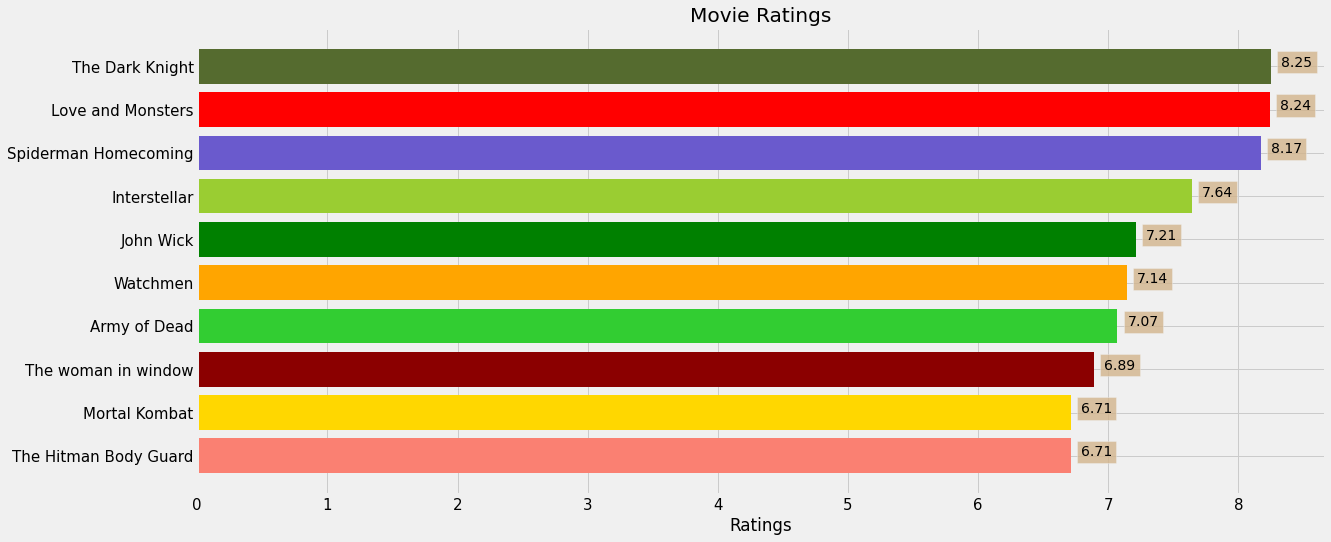

In [ ]:
def addlabels(x,y):
    for i in range(len(y)):
        ax.text(9.2-(9-x[i]), y[i], x[i], ha = 'center',
                 Bbox = dict(facecolor = 'tan', alpha =.8))
  

np.random.seed(1201546)
fig , ax = plt.subplots(1,1)
xtick = [0,1,2,3,4,5,6,7,8]
ax.barh(df_rank_sorted['movies'], df_rank_sorted['rating'], align='center',color=['darkolivegreen','red','slateblue','yellowgreen','green','orange','limegreen','darkred','gold','salmon'])
ax.set_yticks(df_rank_sorted['movies'])
ax.set_xticklabels(xtick,fontsize=15)
ax.set_yticklabels(df_rank_sorted['movies'],fontsize=15)
ax.invert_yaxis()  # labels read top-to-bottom
addlabels(df_rank_sorted['rating'],df_rank_sorted['movies'])
ax.set_xlabel('Ratings')
ax.set_title('Movie Ratings')
fig.set_size_inches(18,8)
plt.style.use('fivethirtyeight')
plt.show()
